Aim
===

To build a spatio-temporal simulator that can predict the spread of
Covid-19 in Kerala under different mitigation strategies. We hope that
this will be useful for experts in community health to corroborate their
intuition against a mathematical prediction.

Key features
============

1.  The resolution of the model is at the smallest local self-governing
    division (LSGD) in Kerala. That is, grama panchayat, municipality or
    municipal corporation.

2.  The predictions are based on available information about the
    characteristics of the disease, the geographic and demographic data
    of Kerala and the statistics of reported cases so far.

3.  The time evolution of the disease in each LSGD is modelled using a
    deterministic [SEIR
    model](https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SEIR_model)
    fine-tuned for Covid-19.

4.  The mixing of population between panchayats is based on the
    [*gravity model* for human
    mobility](https://en.wikipedia.org/wiki/Gravity_model_of_migration)

5.  Spatio-temporal effect of various lockdown strategies can be tried
    out by the user. Some examples of lockdown strategies include

    1.  Lockdown a panchayat for $d$ days if there are more than $c$
        active cases in that panchayat.  
    2.  Lockdown a panchayat and its neighbouring panchayats for $d$
        days if there are more than $c$ active cases in that panchayat.

6.  A lockdown strategy will be declared as *safe* if the demand for
    number of cases needing hospitalisation is within the capacity of
    the corresponding LSGD at every point in time. Other strategies will
    be declared as *unsafe*. A quality parameter will be reported for
    each safe strategy tried. The quality parameter is equal to the
    average number of working days (non-lockdown days) per person for
    the next year.

7.  The system will automatically try out various lockdown strategies in
    the backend and provide a small set of safe strategies which acheive
    high values for the above quality parameter.

User interface
==============

1.  A web dashboard like
    [Covid19-Scenarios](https://covid19-scenarios.org/) with added
    map-based animations like
    [OurWoldInData](https://ourworldindata.org/grapher/total-covid-deaths-per-million)
    for projected data.

2.  The user can try out the effect of various spatio-temporal lockdown
    strategies like those available in
    [CovidMeasures](https://covid-measures.github.io/)

3.  A discussion forum (not sure if it is needed or not)

4.  A logging of crowd-sourced high quality strategies (again, not sure)

Time evolution (SEIR Model)
===========================

A person gets infected by SARS-CoV-2 (Covid-19) virus when she comes in
contact (either directly or via a shared surface) with an infectious
person. A fraction of such people will start showing symptoms within $2$
to $14$ days (average $5.2$ days) and the symptoms will typically last
for around $10$ days. This is called as the *health timeline* in the
figure below. But what matters more for modelling is the *infectivity
timeline*, which is the period during which an infected person is
infectious or contagious. This period is estimated to start typically
from about $1$ to $2$ days before the onset of symptoms and lasts
typically for about $7$ days. This period is marked as $I$ (Infectious)
in the infectivity timeline. The period before that, starting from the
day of contact is marked as $E$ (Exposed or Latent). This is when the
virus is multiplying in her body but is still not numerous enough to be
infectious. The period after $I$ is marked as $R$ (Removed). This is
when she is no longer infectious. She might still have symptoms at this
stage and will typically take another $8$ or more days to be cured. Note
that the word “typically” is intentionally overused in this paragraph.
All these timelines vary from person to person depending on their health
conditions and viral load transmitted at contact. The numbers reported
are averages picked from most WHO reports.

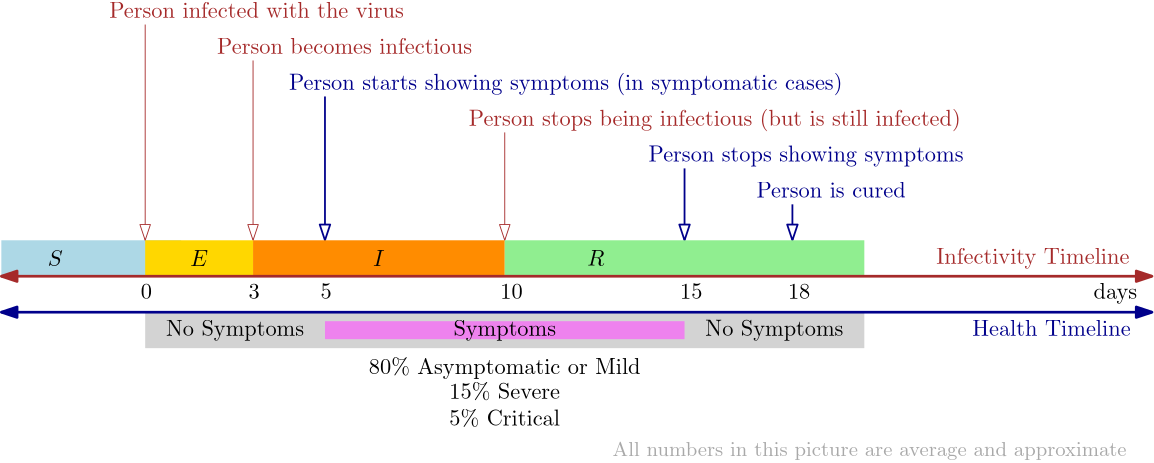

The SEIR model of disease spread is based on the infectivity timeline
above. It considers the total population $N$ in a region as being split
into four compartments based on their stage of infection. The number of
people in each compartment change with time but they always add to $N$.

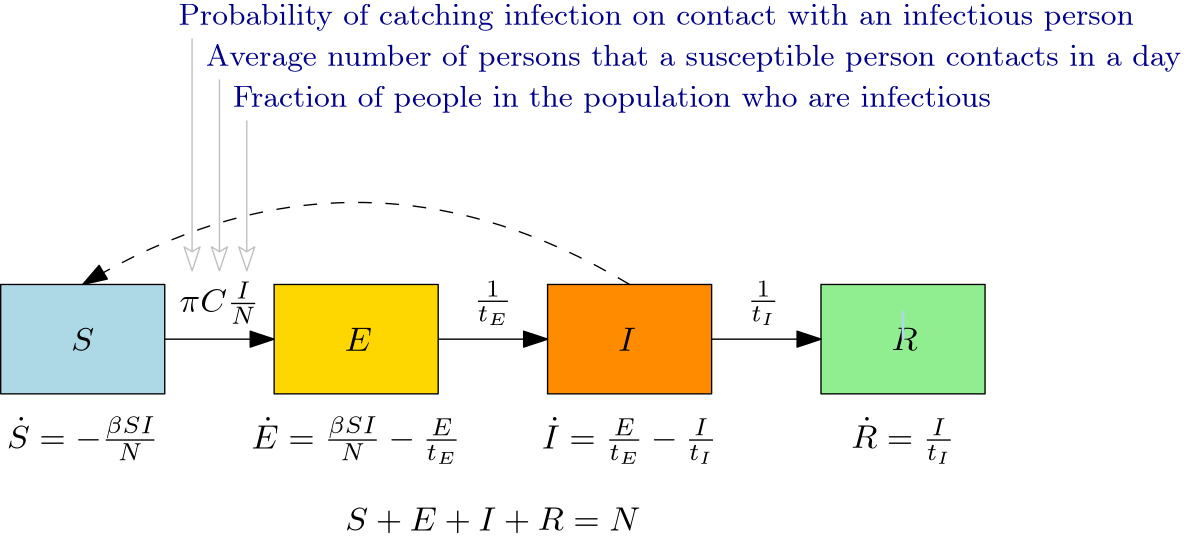

Temporal evolution equations
----------------------------

$$
\begin{aligned}
\dot S_i     &= -\beta S_i \frac{I_i}{N_i} \\
\dot E_i     &= \beta S_i \frac{I_i}{N_i} - \frac{E_i}{t_E}\\
\dot I_i     &= \frac{E_i}{t_E} - \frac{I_i}{t_I}\\
\dot R_i     &= \frac{I_i}{t_I}\\
\end{aligned}
$$

Here

-   $\beta = \pi c$, where

    -   $\pi$ is the probability that a susceptible person who contacts
        an infectious person catches the disease (not all contacts
        transmit the disease)

    -   $c$ is the expected number of people that a susceptible person
        contacts in a day. Going further we will have to model it as
        $c = c_h + c_w$, where $c_h$ and $c_w$ are the expected number
        of people that a susceptible person contacts at home and
        work/school respectively.

    -   $c \frac{I_i}{N_i}$ therefore, is the expected number of
        infectious people that a susceptible person contacts in a day.

    -   $\pi c \frac{I_i}{N_i}$ therefore, is the probability that that
        a susceptible person catches the disease in a day.

-   $t_E$ and $t_I$ are the mean time that a person spends in the
    respective compartments, before moving onto the next.

-   The time variable is hidden in the above equations for readability.
    $S_i$ should be read as $S_i(t)$ and $\dot S$ should be read as
    $S(t+1) - S(t)$, and so on.

Current parameter choices
-------------------------

-   $\pi \approx 0.02$, this can reduce with the use of masks and
    regular cleansing.
-   $c_h \approx 5$
-   $c_w$ is typically 15 on a normal day and 0 on a lockdown day.
-   $t_E \approx 3$
-   $t_I \approx 7$

Spatial mixing
==============

We say that a person *travels* from region $R_1$ to region $R_2$, if she
lives in $R_1$ but works mostly in $R_2$. We will assume that there are
$r$ regions in total.

Gravity model
-------------

The number of people $T_{i,j}$ travelling for work from region $R_i$ to
region $R_j$ in a day is modelled as

$$
T_{i,j} = T_i \frac {N_i J_j}{d_{i,j}^2},
$$ where

-   $N_i$ is the population of region $R_i$.

-   $J_j$ is the number of non-agricultural job opportunities in $R_j$.
    It will be great if one can find these numbers from a primary
    source. In the absence of such a source, we model it as
    $J_j = \zeta N_j$, where

    -   $\zeta = 0.1$ for grama panchayats,
    -   $\zeta = 0.2$ for municipalities and
    -   $\zeta = 0.3$ for corporations

    *Notes.* Only the relative magnitudes of the three zeta’s matter. We
    consider only non-agricultural jobs, since census data considers
    that agricultural sector jobs has very little contribution to
    long-distance (more than 5 km) daily commuting.

-   $d_{i,j}$ is the travel distance between regions $R_i$ and $R_j$.

    The dependence on the distance is assumed to be
    $T_{i,j} \propto 1/d_{i,j}^2$. This dependence is usually calibrated
    based on real data of job movement in a region. In the absence of
    such data for Kerala, we are making an arbitrary choice here based
    on a subjective validation of the results.

-   We can estimate the proportionality constant using the relation
    $$ T_i = \sum_{j \neq i} T_{i,j},$$ where $T_i$ is the total number
    of people who travel out for work from region $R_i$. Census 2011
    contains a histogram of daily travel distances of non-agricultural
    workers at district level resolution. Since the histogram is coarse
    and there is no huge variation across districts, we estimate $T_i$
    as $T_i = \mu N_i$, where

    -   $\mu = 0.09$ for regions with area less than $25$ square
        kilometers
    -   $\mu = 0.04$ for regions with area between $25$ and $100$ square
        kilometers
    -   $\mu = 0.02$ for regions with area more than $100$ square
        kilometers

    The values 9%, 4% and 2% used above are based, respectively, on the
    2011 census estimate of the percentage of population travelling more
    than $5$, $10$ and $20$ kilometers for work (Kerala overall
    statistics).

-   Putting it all together, $$
    T_{i,j} = T_i \frac{(J_j/d_{i,j}^2)}{\sum_{k \neq i}(J_k/d_{i,k}^2)},~ \forall j \neq i,
    $$ and then compute $T_{i,i} = N_i - \sum_{j \neq i} T_{i,j}$.
    Theoretically $T_{i,i}$ should be $N_i - T_i$, but I’m seeing
    rounding errors creeping in.

*Optimisation notes.*

-   It is better to compute the $T_i$ and $J_i$ arrays first rather than
    computing it as $\mu N_i$ and $\zeta N_i$ inside the nested loops.

-   It might be fastest to compute $T_{i,j}$ values as a $r \times r$
    matrix in three stages.

    1.  Fill a matrix $A$ with $A[i,j] = J_j/d_{i,j}^2$ for $j \neq i$
        and $0$ for $j = i$.
    2.  Divide each row of $A$ by the sum of that row so that finally
        each row sums to $1$.
    3.  Multiply each row of $A$ with $T_i$ to get the $T_{i,j}$ matrix
        (except the diagonal entries)
    4.  Set the diagonal entries $T_{i,i}$ as $N_i$ minus the sum of
        $i$-th row of the $T_{i,j}$ matrix obtained in the previous
        step.

Travel Matrix to Contact Matrix
===============================

1.  **Workplace Contact Matrix.** This is an $r \times r$ matrix $C_w$
    in which the entry $C_w[i,j]$ is the expected number of people from
    region $R_j$ that a susceptible person from region $R_i$ will
    contact at workplace/school in a day. We model it as

    $$
    C_w[i,j] = c_w \sum_{k=1}^{r} \frac{T_{i,k}}{N_i} \frac{T_{j,k}}{\sum_{l=1}^{r} T_{l,k}}
    $$

    If you consider a person picked uniformly at random from region
    $R_i$, the term $\frac{T_{i,k}}{N_i}$ can be interpretted as the
    probability that she goes for work in region $R_k$ and the term
    $\frac{T_{j,k}}{\sum_{l=1}^{r} T_{l,k}}$ can be interpretted as th
    probability that a person she contacts at workplace (in region
    $R_k$) has come to work there from region $R_j$. Notice that the
    total number of people in region $R_k$ during the day is not $N_k$
    but $\sum_{l=1}^{r} T_{l,k}$. Since we have chosen $T_{k,k}$ as
    $N_k - T_k$, this sum will account for the people leaving and
    entering $R_k$ for work.

2.  **Contact Matrix.** The contact matrix $C$ is obtained by adding
    $c_h$ to each diagonal entry of $C_w$. This is justified since all
    household contacts happen in the region of a person’s living.

Spatio-Temporal Evolution
=========================

$$
\begin{aligned}
\dot S_i &= -\pi S_i \sum_{j=1}^{n} C_{i,j} \frac{I_j}{N_j} \\
\dot E_i &=  \pi S_i \sum_{j=1}^{n} C_{i,j}\frac{I_j}{N_j} - \frac{E_i}{t_E} \\
\dot I_i &=  \frac{E_i}{t_E} - \frac{I_i}{t_I}\\
\dot R_i &=  \frac{I_i}{t_I}
\end{aligned}
$$

The sum $\sum_{j=1}^{n} C_{i,j} \frac{I_j}{N_j}$ can be implemented as a
matrix-vector multiplication if that will speed up the code.

Modelling Mitigation strategies
===============================

Mitigation strategies to be included in v0.1
--------------------------------------------

1.  Break the Chain + Mask
    -   Only text message
    -   $\pi \rightarrow \epsilon_{BC} \times \pi$ from March 16, 2020
2.  Complete Lockdown
    -   Date Range
    -   $c_w \rightarrow \epsilon_{LD} c_w$ during the lockdown date
        ranges
3.  District Border Closure
    -   Date Range
    -   $C_w[i,j] \rightarrow \epsilon_{DB} C_w[i,j]$, if $R_i$ and
        $R_j$ are regions from two different districts.
4.  Predefined Hotspots
    -   Upload csv of current hotspots, with date range for each (name
        clash?)
    -   To simulate lockdown of one region $R_i$, set
        -   $C_w[i,j] \rightarrow \epsilon_{HS} C_w[i,j]$, for all $j$,
            and
        -   $C_w[j,i] \rightarrow \epsilon_{HS} C_w[j,i]$, for all
            $j \neq i$

        during the selected date range.
    -   Repeat this for every region in the list of hotspots.
    -   Notice that if both $R_i$ and $R_j$ are under lockdown,
        $C_w[i,j]$ will get scaled by $\epsilon_{HS}^2$, which agrees
        with the transportation model.
5.  Dynamic Hotspots
    -   Any LSGD with an active case is declared as a hotspot for the
        next $7$ days or till the number of active cases goes below
        $0.5$, whichever is later.
    -   A lockdown is simulated as in the previous case.
6.  Red Zone
    -   14 checkboxes \| Visual select from map
    -   Date Range
    -   For every region $R_i$ in the red zone, set
        -   $C_w[i,j] \rightarrow \epsilon_{RZ} C_w[i,j]$, for all $j$,
            and
        -   $C_w[j,i] \rightarrow \epsilon_{RZ} C_w[j,i]$, for all
            $j \neq i$

        during the selected date range.
7.  Orange Zone
    -   14 checkboxes \| Visual select from map
    -   Date Range
    -   Simlulation is same as red zone but with $\epsilon_{OZ}$ instead
        of $\epsilon_{RZ}$.

where,

-   $\epsilon_{BC} = 2/3$,
-   $\epsilon_{DB} = 1/5$,
-   $\epsilon_{OZ} = 1/5$,
-   $\epsilon_{RZ} = 1/10$,
-   $\epsilon_{LD} = 1/10$,
-   $\epsilon_{HS} = 1/50$

Scenarios
---------

1.  Initialise with today’s reality

2.  Initialise with a past reality and validate against today’s reality.

    -   Is it agreeing at state/district level?

Justifying the model and parameter choices
==========================================

Team
----

-   Arun Ramachandran
-   Birenjith P. S.
-   Deepak R.
-   Sajith V. K.
-   Sreeram H.

### Acknowledgements

-   Dr. B. K. Bhavathrathan, Assistant. Professor, Civil Engineering,
    IIT Palakkad.

Tried and ruled out
===================

Radiation model
---------------

The number of people $T_{i,j}$ travelling from region $R_i$ to region
$R_j$ on a working day is modelled as

$$
T_{i,j} = T_i \frac {J_i J_j}{(J_i + S_{i,j})(J_i + J_j + S_{i,j})},
$$ where

-   $J_i$ is the number of job opportunities in $R_i$. It will be great
    if one can find these numbers from a primary source. In the absence
    of such a source, we model it as $J_i = \zeta N_i$, where

    -   $N_i$ is the population of $R_i$
    -   $\zeta = 0.1$ for grama panchayats,
    -   $\zeta = 0.2$ for municipalities and
    -   $\zeta = 0.3$ for corporations

    (Only the relative magnitudes of the three zeta’s matter)

-   $T_i$ is the total number of people who travel out for work from
    region $R_i$. At a larger granularity, this data for each region may
    be available from Census. Otherwise, one can model it as
    $T_i = \mu N_i$, where

    -   $\mu = 0.1$ for grama panchayats and municipalities, and
    -   $\mu = 0.05$ for corporations.

-   $S_{i,j}$ is the number of jobs in all the regions (except $R_i$
    itself) which are closer to $R_i$ than $R_j$. That is,

    $$
    S_{i,j} = \sum_{k=1}^{r} \{J_k :~ d(R_k, R_i) \leq d(R_j, R_i)\} - J_i - J_j.
    $$

    We will also set $T_{i,i} = N_i - T_i$, which can be interpreted as
    the number of people from region $R_i$ travelling to $R_i$ itself.
    This will make the future summations easier to write.

### LSGD size adjustment to Radiation model

In the context of Kerala, the municipal corporations are much larger in
area than muncipalities and grama panchayats. We assume that on a grosss
average, a person living in a grama panchayath or municipality needs to
travel 5 km to leave her grama panchayat or municipality, while a person
living in a corporation needs to travel 10 km to leave her corporation.
Based on the 2011 census, data the proportion of population who travel
more than 5 km to work is about $10%$ and more than 10 km to work is
about $5%$. There is a small urban-rural difference between these
numbers, but we ignore it since many grama panchayaths in kerala are
also urban in nature. Hence we include the following tweak to the
radiation model.

-   $\mu = 0.1$ for panchayats and municpalities
-   $\mu = 0.05$ for corporations

### Radiation Model (Assumptions)

The *radiation model* was proposed by Simini et al.[1] in 2012 as an
alternative to the very popular gravity model. The model equation is
derived based on three assumptions, one behavioral and two economic.

1.  A person who decides to travel out of her home panchayat for a job,
    travels to the nearest panchayat where she gets a job that pays more
    than the highest paying job in her own panchayat.

2.  The job salaries are independent samples drawn from the same
    probability distribution. This, for example, means that the average
    salary is the same in all panchayats and salaries do not influence
    each other. Notice that, the maximum salary is still likely to be
    more in panchayats were there are more jobs.

3.  The number of jobs in a panchayat is proportional to the number of
    people living in that panchayat.

To paint an analogy, one can imagine every job to be a tower at the job
location whose height is the daily wage. The behavioural assumption
above says that, when a person is unsatisfied with the towers in her
panchayat, she climbs to the top of the tallest tower in her panchayat
and looks all around. Among all the towers that are taller than the one
she is standing on, she chooses the one which is at a panchayat closest
to her panchayat. That’s the job she will settle for.

One can debate on the “correctness” of the above assumptions. But the
claim to fame of a model is not its correctness but its usefulness.
Studies have compared the predictions of the model against the actual
job-seeking patterns in various places and found good fitment (add
references). The feature that makes this model most useful is that it is
parameter-free and hence “universal”.

### From assumptions to the formula.

See the appendix of Simini et al.[2] for a derivation using continuous
probability distributions. Here we give an alternate derivation using
random permutations.

Let $N_i$ and $N_j$, respectively, be the number of jobs in panchayats
$R_i$ and $R_j$. Let $d$ be the distance between $R_i$ and $R_j$. A
panchayat $R_k$, $k \neq i$, is said to be overlooked by $R_i$ in favour
$of R_j$ if the distance between $R_i$ and $R_k$ is at most $d$. Let
$S_{i,j}$ be the number of jobs that are in the panchayats overlooked by
$R_i$ favour of $R_j$. Let’s assume that a person living in panchayat
$R_i$ decides to find a job ourside $R_i$. We will show that the
probability $p_{i,j}$ that she settles for a job in panchayat $R_j$
($j \neq i$) is

$$
p_{i,j} = \frac {N_i N_j}{(N_i + S_{i,j})(N_i + N_j + S_{i,j})}.
$$

We have $N = N_i + N_j + S_{i,j}$ towers which are relevant for the
discussion. Let $H_i$, $H_j$ and $H_{i,j}$, respectively, denote the
maximum heights of towers in $R_i$, $R_j$ and the panchayats overlooked
by $R_i$ in favour of $R_j$. The person settles in $R_j$ if and only if
$H_{i,j} < H_i < H_j$. Once we notice that only the relative heights of
the towers matter we can rank the towers $1, 2, \ldots, N$ in the
increasing order of their heights and then ignore their actual heights.
This ranking gives a permutation of numbers $1$ to $n$. Assumption 2
ensures that each of the $n!$ possible permutations are equally likely
to occur. $H_j$ is larger than both $H_i$ and $H_{i,j}$ if and only if
rank $n$ falls among the $N_j$ towers in $R_j$. Hence the probability of
this is $N_j/(N_i + N_j + S_{i,j})$. Note that this event is independent
of the relative order within the $N_i + S_{i,j}$ towers in $R_i$ and the
overlooked panchayats. Thankfully, only the relative ordering of those
$N_i + S_{i,j}$ towers determine whether $H_{i,j} < H_i$, and hence it
is independent of the previous event. $H_{i,j} < H_i$ if and only if the
largest rank among those $N_i + S_{i,j}$ towers falls among the $N_i$
towers in panchayat $R_i$. This happens with probability
$N_i/(N_i + S_{i,j})$. We get the required result since $p_{i,j}$ is the
product of the two probabilities mentioned above.

Assumption 3 helps us to replace the number of jobs in the above formula
with the number of people in each region.

### Heterogenous Radiation Model (Only if the above tweak fails)

There is a considerable difference in average incomes across rural and
urban india (a factor of two). Hence one of the key assumptions for
radiation model breaks down. Hence we breakdown the daily commuting to
four types - rural-rural, rural-urban, urban-rural, urban-urban and
calculate four travel matrices separately.

1.  $T_i$ is the total number of people who travel out for work from
    region $R_i$. Census 2011 provides the distribution daily
    commute-distance[3] “other workers” [4] per district. In kerala the
    percentage of people with travel distance more than 1,2,5,10,20,50
    kilometers are, respectively,

[1] Simini, Filippo, Marta C. González, Amos Maritan, and Albert-László
Barabási. “[A universal model for mobility and migration
patterns.](https://doi.org/10.1038/nature10856)” Nature 484, no. 7392
(2012): 96-100.

[2] Simini, Filippo, Marta C. González, Amos Maritan, and Albert-László
Barabási. “[A universal model for mobility and migration
patterns.](https://doi.org/10.1038/nature10856)” Nature 484, no. 7392
(2012): 96-100.

[3] Census 2011 defines *commute distance* as distance between place of
residence to place of work.

[4] Census 2011 defines *other workers* as follows. Workers other than
cultivators, agricultural labourers or workers in Household Industry, as
defined above are termed as ‘Other Workers’ (OW). Examples of such type
of workers are government servants, municipal employees, teachers,
factory workers, plantation workers, those engaged in trade, commerce,
business, transport, banking, mining, construction, political or social
work, priests, entertainment artists, etc.